In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from tqdm import tqdm
import pickle
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline


In [2]:
df_sample_submission = pd.read_csv('datasets/sample_submission.csv')
df_test = pd.read_csv('datasets/test.csv')
df_train = pd.read_csv('datasets/train.csv')

In [3]:
pd.set_option('max_colwidth',200)

In [7]:
display(df_sample_submission.sample(3))
display(df_test.sample(3))
display(df_train.sample(3))

,id,target
2611,8716,0
2219,7409,0
505,1655,0


,id,keyword,location,text
1439,4767,evacuated,NaN,A house was evacuated in Orakei after a bank collapsed and trees were felled by strong winds in Auckland ... http://t.co/UCuCmKypdN #NZ
805,2646,crashed,USA,Website Malfunctioning? PHP Scripts not working? Database Crashed? Need a Unique Script? PHP PRO to the rescue! http://t.co/LadH9Oo086
2508,8357,ruin,Planet Earth,Any man who tries to be good all the time is bound to come to ruin among the great number who are not good.


,id,keyword,location,text,target
1317,1901,burning,??t?a,Now playing: Boat Club - Memories on London Burning Web Radio - http://t.co/umtNNImTbM,0
2584,3708,destroyed,NaN,@alanhahn @HDumpty39 Daughtery would get destroyed on twitter. His comments are emotionally driven rants with little factual basis,0
4539,6453,injured,Worldwide,Top Stories - Google 4 dead dozens injured in Gaza blast near house leveled in summer warÛ_ http://t.co/P3o71DZ992,1


<AxesSubplot:xlabel='target', ylabel='count'>

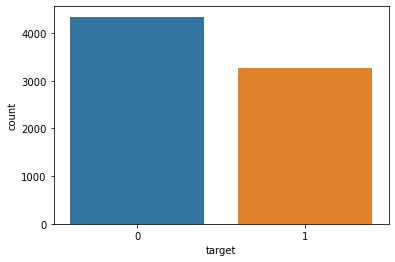

In [39]:
sns.countplot(x = df_train["target"], data = df_train)

Можно начать с самой простой модели

In [8]:
df_train.isnull().mean()

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [17]:
df_sample_submission.columns

Index(['id', 'target'], dtype='object')

In [18]:
df_sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [21]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3


In [16]:
df_test.columns

Index(['id', 'keyword', 'location', 'text'], dtype='object')

In [22]:
df_sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [20]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


In [11]:
print(df_sample_submission.shape)
print(df_train.shape)
print(df_test.shape)

(3263, 2)
(7613, 5)
(3263, 4)


In [23]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [25]:
df_train.loc[lambda x:x['target'] == 1]['text']

0                                                                           Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1                                                                                                          Forest fire near La Ronge Sask. Canada
2           All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3                                                                               13,000 people receive #wildfires evacuation orders in California 
4                                                        Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
                                                                          ...                                                                    
7608                                                          Two giant cranes holding a bridge collapse into nearby homes h

### Натренируем некоторые модели популярные

In [19]:
corpus = df_train['text'].values

In [20]:
#Lemmatization function
def lemmatization(texts):
    nlp = spacy.load("en_core_web_sm")
    texts_out = []
    for text in tqdm(texts):
        doc = nlp(text)
        new_text = []
        for token in doc:
            new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [25]:
print(corpus[0:10])
lemmatized_texts=lemmatization(corpus)
print(corpus[0:10])

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'
 "I'm on top of the hill and I can see a fire in the woods..."
 "There's an emergency evacuation happening now in the building across the street"
 "I'm afraid that the tornado is coming to our area..."]


100%|██████████████████████████████████████████████████████████████████████████████| 7613/7613 [04:28<00:00, 28.31it/s]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'
 "I'm on top of the hill and I can see a fire in the woods..."
 "There's an emergency evacuation happening now in the building across the street"
 "I'm afraid that the tornado is coming to our area..."]


In [28]:
#Сериализуем лемматизированные тексты чтобы не возвращаться к этому
with open("lemmatized_texts.pkl", "wb") as f:
    pickle.dump(lemmatized_texts, f)

In [4]:
##Загрузим сериализованные датасеты
with open("lemmatized_texts.pkl", "rb") as f:
    lemmatized_texts = pickle.load(f)

In [5]:
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z ]', ' ', text).split())

In [6]:
stop_words = set(stopwords.words('english'))
preprocessed_corpus=[]
for i in tqdm(range(len(lemmatized_texts))):
    preprocessed_corpus.append((clear_text(str.lower(lemmatized_texts[i]))))

100%|███████████████████████████████████████████████████████████████████████████| 7613/7613 [00:00<00:00, 47287.53it/s]


In [10]:
# !pip3 install wordcloud

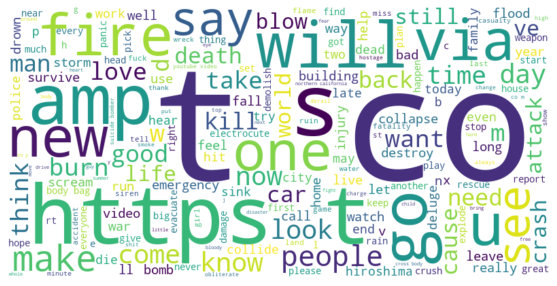

In [42]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(preprocessed_corpus))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Следует основательно почистить текста. Для этого посмотрим слова,биграммы,триграммы

#### Отдельные слова

In [40]:
count_vect = CountVectorizer(stop_words=stop_words) 
bow = count_vect.fit_transform(preprocessed_corpus) 

print("Размер мешка без учёта стоп-слов:", bow.shape)

Размер мешка без учёта стоп-слов: (7613, 20335)


In [43]:
word_list=count_vect.get_feature_names() 
count_list = bow.sum(axis=0).A1

In [44]:
x = dict(zip(word_list,count_list))
g={k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}
result_series = pd.Series(g)

In [45]:
result_series[0:20]

co        4741
http      4309
https      412
like       394
get        361
fire       358
amp        344
go         287
new        230
via        220
news       212
one        209
people     201
say        199
would      185
see        183
year       177
make       176
video      175
kill       172
dtype: int64

#### Биграммы

In [46]:
count_vect = CountVectorizer(ngram_range=(2, 2),stop_words=stop_words) 
bow = count_vect.fit_transform(preprocessed_corpus) 

print("Размер мешка без учёта стоп-слов:", bow.shape)

Размер мешка без учёта стоп-слов: (7613, 55380)


In [47]:
word_list=count_vect.get_feature_names() 
count_list = bow.sum(axis=0).A1


In [48]:
x = dict(zip(word_list,count_list))
{k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}
g={k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}
result_series = pd.Series(g)

In [49]:
result_series[0:20]

http co                4306
https co                411
body bag                 62
suicide bomber           60
look like                55
burn building            52
video http               44
youtube video            43
like youtube             42
northern california      41
cross body               40
oil spill                39
california wildfire      35
year old                 35
suicide bombing          34
mass murder              33
news http                32
bomber detonate          31
feel like                31
fire http                31
dtype: int64

#### Триграммы

In [50]:
count_vect = CountVectorizer(ngram_range=(3, 3),stop_words=stop_words) 
bow = count_vect.fit_transform(preprocessed_corpus) 

print("Размер мешка без учёта стоп-слов:", bow.shape)

Размер мешка без учёта стоп-слов: (7613, 57270)


In [52]:
word_list=count_vect.get_feature_names() 
count_list = bow.sum(axis=0).A1

In [53]:
x = dict(zip(word_list,count_list))
{k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}
g={k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}
result_series = pd.Series(g)

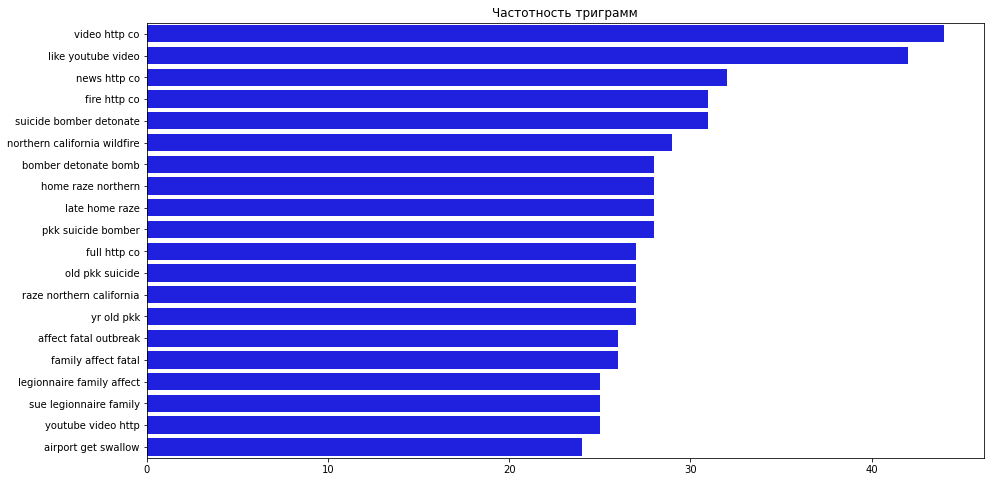

In [54]:
plt.figure(figsize=(15,8))
sns.barplot(y=result_series[0:20].index, x=result_series[0:20].values,color='blue')
plt.title("Частотность триграмм")
plt.show()

In [60]:
print(np.array(features).shape)
print(df_train.shape)

(7613,)
(7613, 5)


In [38]:
features = preprocessed_corpus
print(np.array(features).shape)
target = df_train['target']
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state = 12345, test_size=0.2)

(7613,)


In [8]:
count_tf_idf = TfidfVectorizer() 
tf_idf = count_tf_idf.fit_transform(features_train) 
tf_idf2 = count_tf_idf.transform(features_test)

#### Логистическая регрессия

In [9]:
parameters = {'C':range(1,10,1)}

log_regr_rand=RandomizedSearchCV(LogisticRegression(class_weight='balanced',penalty='l2'), parameters, cv=5, random_state=12345,scoring='f1')
log_regr_rand.fit(tf_idf, target_train)
print('Лучшие параметры: ',log_regr_rand.best_params_)
log_regression_model=log_regr_rand.best_estimator_

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры:  {'C': 5}


In [11]:
prediction = log_regression_model.predict(tf_idf2)
log_regression_result=f1_score(target_test, prediction)
print('F1 score for logistic regression',log_regression_result)

F1 score for logistic regression 0.7679640718562875


Сравним лог регрессию с CountVectorizer

In [70]:
vectorizer = CountVectorizer()
count_matrix_train = vectorizer.fit_transform(features_train)
count_array_train = count_matrix_train.toarray()

count_matrix_test = vectorizer.fit_transform(features_test)
count_array_test = count_matrix_test.toarray()

In [71]:
#Этот код выполнялся оченьо долго остановил
parameters = {'C':range(1,10,1)}

log_regr_rand=RandomizedSearchCV(LogisticRegression(class_weight='balanced',penalty='l2'), parameters, cv=5, random_state=12345,scoring='f1')
log_regr_rand.fit(count_array_train, target_train)
print('Лучшие параметры: ',log_regr_rand.best_params_)
log_regression_model=log_regr_rand.best_estimator_

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a

KeyboardInterrupt: 

In [ ]:
prediction = log_regression_model.predict(count_array_test)
log_regression_result=f1_score(target_test, prediction)
print('F1 score for logistic regression',log_regression_result)

In [75]:
LGBM_class=LGBMClassifier(num_leaves=30,n_estimators=361)
LGBM_class.fit(tf_idf, target_train)
predictions = LGBM_class.predict(tf_idf2)
print(f1_score(target_test, predictions))

0.7296416938110748


Почему то результат хуже регрессии

In [14]:
### Почистим текст от мусорных слов посмотрим что будет 
stop_words=('https','co','https')
count_tf_idf = TfidfVectorizer(stop_words=stop_words) 
tf_idf = count_tf_idf.fit_transform(features_train) 
tf_idf2 = count_tf_idf.transform(features_test)

In [15]:
parameters = {'C':range(1,10,1)}

log_regr_rand=RandomizedSearchCV(LogisticRegression(class_weight='balanced',penalty='l2'), parameters, cv=5, random_state=12345,scoring='f1')
log_regr_rand.fit(tf_idf, target_train)
print('Лучшие параметры: ',log_regr_rand.best_params_)
log_regression_model=log_regr_rand.best_estimator_

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a

Лучшие параметры:  {'C': 5}


In [16]:
prediction = log_regression_model.predict(tf_idf2)
log_regression_result=f1_score(target_test, prediction)
print('F1 score for logistic regression',log_regression_result)

F1 score for logistic regression 0.7691154422788605


### Прогнозироавние

In [19]:
df_test.isnull().mean()

id          0.000000
keyword     0.007968
location    0.338645
text        0.000000
dtype: float64

In [22]:
df_train.isnull().mean()

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [26]:
df_train['keyword'].shape

(7613,)

In [24]:
df_train['keyword'].nunique()

221

In [27]:
df_train['keyword']=df_train['keyword'].fillna('nothing')

In [30]:
df_train['keyword'].shape

(7613,)

In [31]:
tf_idf.shape

(6090, 17567)

In [39]:
print(np.array(features).shape)

(7613,)


In [43]:
print(df_train['keyword'].values.shape)

(7613,)


In [53]:
np.hstack([df_train['keyword'].values, tf_idf_all])[-1]

<7613x20461 sparse matrix of type '<class 'numpy.float64'>'
	with 108022 stored elements in Compressed Sparse Row format>

In [66]:
tf_idf_all.shape

(7613, 20461)

In [61]:
type(tf_idf_all)

scipy.sparse.csr.csr_matrix

In [42]:
### Можно обучить тренировочный датасет 

stop_words=('https','co','https')
# features = np.hstack([df_train['keyword'].values, tf_idf])
count_tf_idf = TfidfVectorizer(stop_words=stop_words) 
# features = preprocessed_corpus
tf_idf_all = count_tf_idf.fit_transform(preprocessed_corpus) 
print(np.array(preprocessed_corpus).shape)
print((tf_idf_all).shape)
features = np.hstack([df_train['keyword'].values, tf_idf_all])
print(np.array(features).shape)

(7613,)
(7613, 20461)
(7614,)


In [35]:
features.shape

(7614,)

In [36]:
target.shape

(7613,)

In [34]:
target = df_train['target']
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state = 12345, test_size=0.2)

ValueError: Found input variables with inconsistent numbers of samples: [7614, 7613]

Сделаем прогноз:

In [68]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3


### Pipeline

In [ ]:
def text_processor(messy_str):
    

In [71]:
#Create the Logistic Regression pipeline
#First, use the TFIdf with the custom text_processor
#to create the BoW model. Second, pass the BoW model to the ML classifier. 
pipeline = Pipeline([
                     ('tfidf', TfidfVectorizer(analyzer=text_processor, stop_words=stop_words)), #Tokenize message strings into bag-of-word
                     ('lr',LogisticRegression(class_weight='balanced',penalty='l2')), #Train a classifier on the bag-of-words vectors
])

In [72]:
pipeline.fit(X_train, y_train)

NameError: name 'X_train' is not defined

###  Выводы

1. https://habr.com/ru/post/580560/  Ссылка про word_cloud
2. Нужно ли убирать http co и прочие похожие на мусорные слова неизвестно. Попробуем научить модель с ними и без них и посмотрим на метрики

3. https://www.kaggle.com/code/michaelwilder/disaster-tweets-as-an-introduction-to-nlp тетрадка с решением
